In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}
/*Disable scrollbar in a cell*/

<IPython.core.display.Javascript object>

In [2]:
import pandas as pd
import numpy as np
from segregation.aspatial import Entropy
import os
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.stats import truncnorm, norm, beta
import SALib
import multiprocessing as mp
import time
import itertools
from datetime import date
import matplotlib as mpl

import sys
sys.path.insert(0, "../compass")
from parameters import FLAGS

sys.path.insert(0, "../")
from datacrawler import DataCrawler

plt.rcParams.update({'mathtext.default':  'regular' })

In [3]:
name = 'gsa-7pars-2000'
path_to_frame = f'../experiments/{name}/'
frame = pd.read_pickle(f"{path_to_frame}{name}.pkl")

# Construct a dictionary of name (key) and titles for plots (value)
names = {'single_utility_at_max': 'Utility at homogeneity (M)',
            'single_optimal_fraction': 'Optimal fraction ($t_i$)', 
            'radius': 'Radius (r)', 
            'neighbourhood_mixture': 'Neighbourhood mix (b)',
            'alpha': 'Alpha', 
            'school_capacity': 'School capacity (c)',
            'dummy':'Dummy'}
output_names = {'res_seg_new': 'Residential segregation (Theil)',
            'school_seg_new': 'School segregation (Theil)'}

renaming = names.copy()
renaming['utility_at_max'] = names['single_utility_at_max']
renaming['optimal_fraction'] = renaming['single_optimal_fraction']
# renaming['max_steps'] = renaming['max_res_steps']

# Construct lists of input columns and outputs to plot
columns_to_plot = list(names.values())
output_to_plot = list(output_names.values())
data = pd.read_pickle(f"{path_to_frame}data/frame.pkl")

# Rename the columns
data.rename(columns=names, inplace=True)
data.rename(columns=output_names, inplace=True)
parameters = data[columns_to_plot]
output = data[output_to_plot]
output['School - residential'] = data['School segregation (Theil)'] - \
    data['Residential segregation (Theil)']
data['School - residential'] = output['School - residential']

print(data[['res_converged', 'school_converged']].describe())

       res_converged school_converged
count          32000            32000
unique             2                2
top             True             True
freq           31976            31820


/home/eric/.local/share/virtualenvs/compassproject-_5IOlIuy/lib/python3.6/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


# General plot settings

In [4]:
# print(mpl.rcParams.keys)
sns.set(style="whitegrid", font_scale=1.5)
mpl.rcParams['mathtext.default'] = 'regular'
mpl.rcParams['lines.linewidth'] = 3
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['xtick.top'] = True
mpl.rcParams['xtick.bottom'] = True
mpl.rcParams['ytick.left'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['grid.alpha'] = 1

# colors = itertools.cycle((',', '+', '.', 'o', '*'))
markers = ('o', 'v', 's', 'd', '<', '+')

# Parameter distributions when residential process is not converged

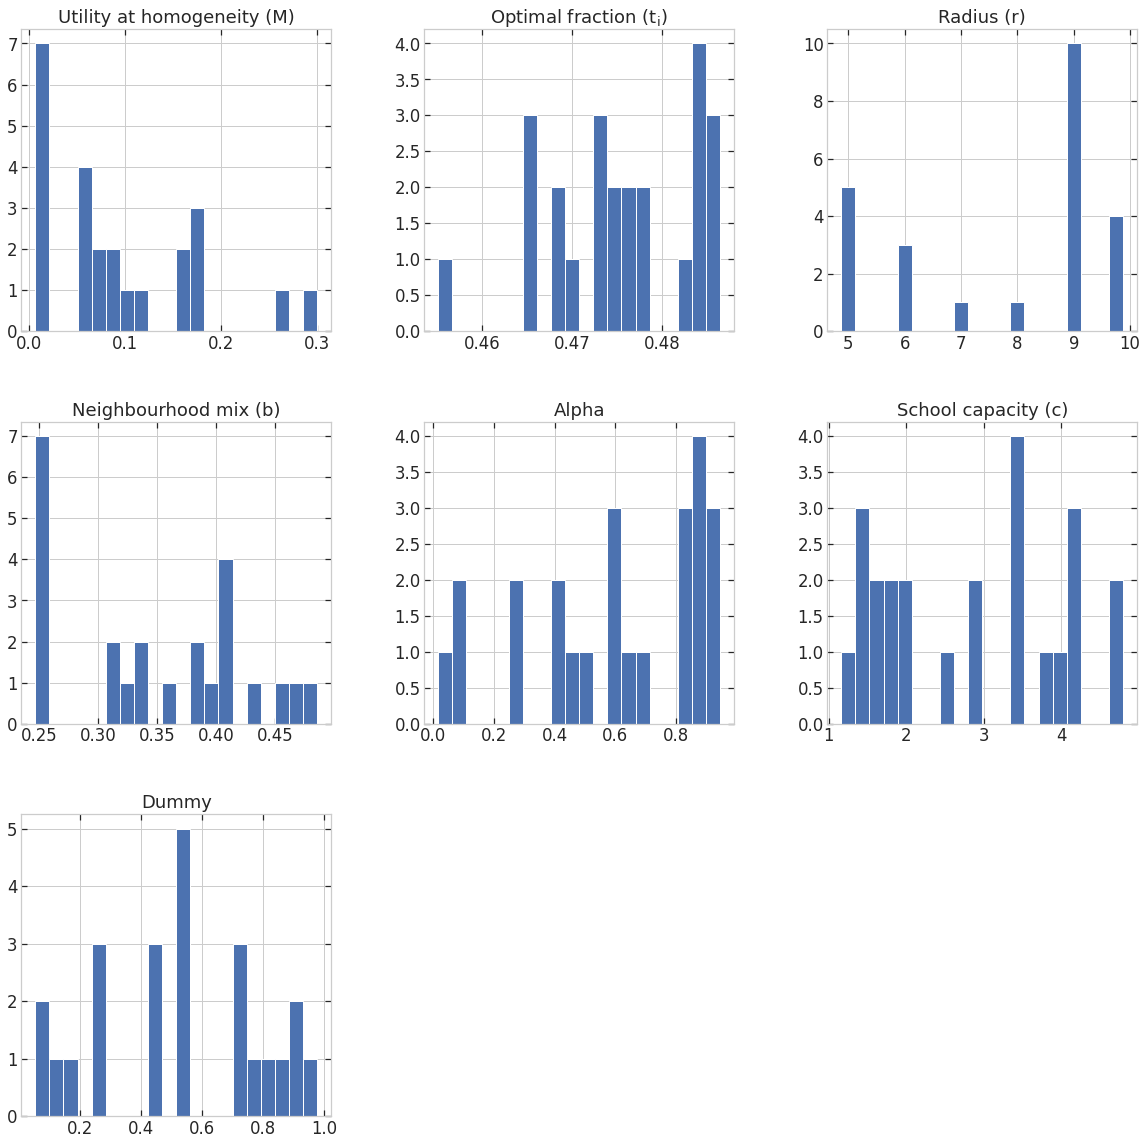

In [5]:
res_not_converged = parameters[data.res_converged==False]
_ = res_not_converged.hist(figsize=(20,20), align='left', bins=20)

# Parameter distributions when school process is not converged

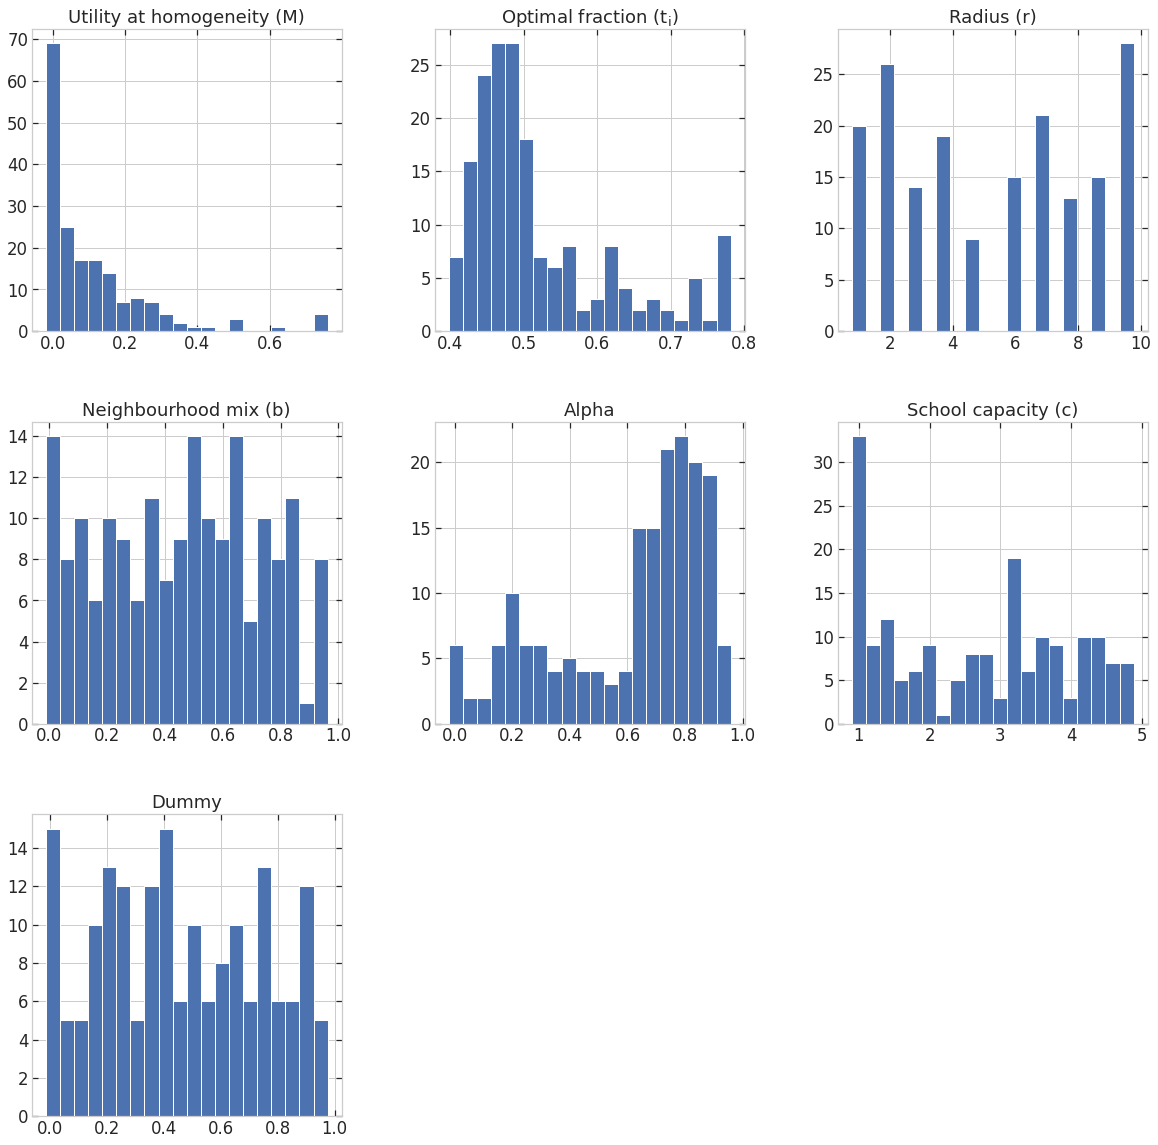

In [6]:
school_not_converged = parameters[data.school_converged==False]
_ = school_not_converged.hist(figsize=(20,20), align='left', bins=20)


# Parameter distributions when residential is fully segregated

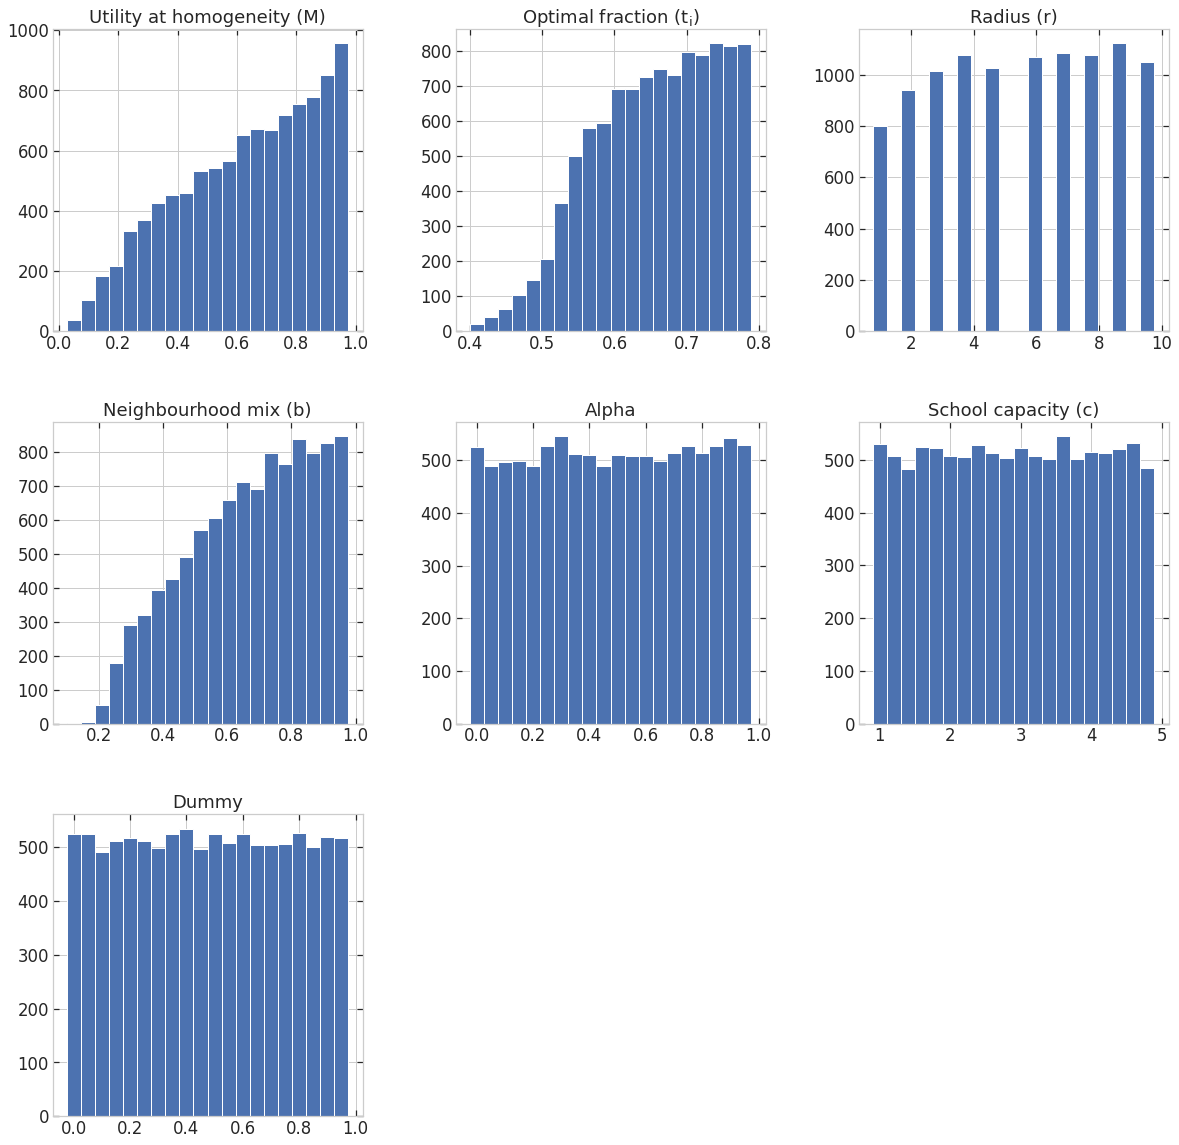

In [7]:
fully_res = parameters[data['Residential segregation (Theil)']>0.99]
_ = fully_res.hist(figsize=(20,20), align='left', bins=20)


# Parameter distributions when schools are fully segregated

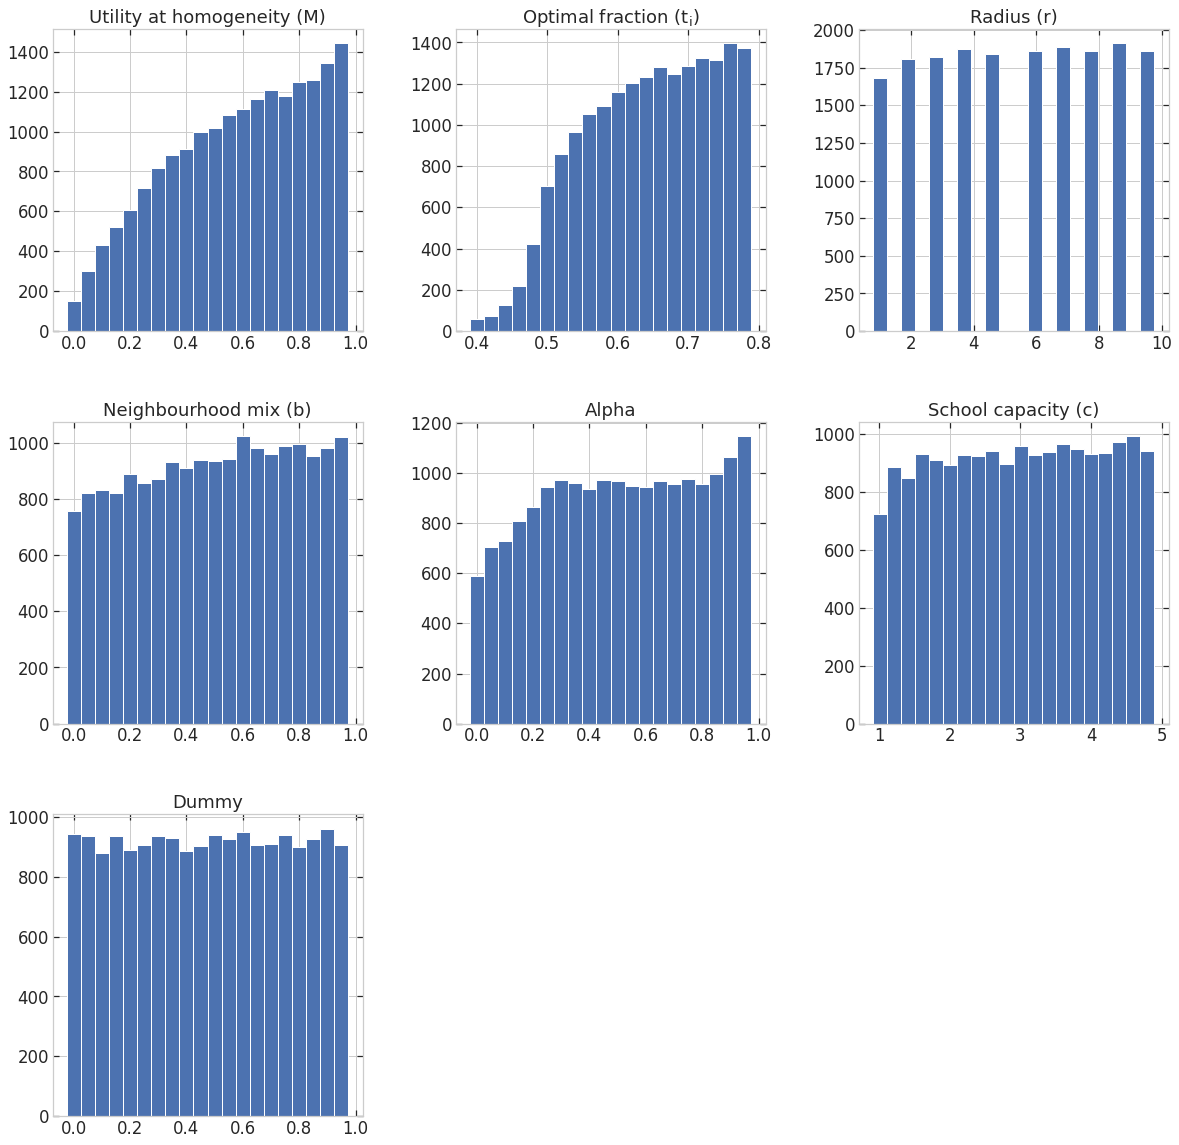

In [8]:
fully_res = parameters[data['School segregation (Theil)']>0.99]
_ = fully_res.hist(figsize=(20,20), align='left', bins=20)

# Function to save figures

In [9]:
# Create directory if it does not exist yet.
plot_path = f'../plots/{name}'
if not os.path.exists(plot_path):
    os.makedirs(plot_path)

def save_figure(plot_path, filename):
    today = date.today()
    _ = plt.savefig(f'{plot_path}/{filename}-{today.strftime("%d-%m-%Y")}.pdf')

In [10]:
def calculate_theil(data):
        """
        Calculate Theil's information index (own implementation).

        Args:
            data (DataFrame): DataFrame where every row corresponds to an
                organisational unit (e.g., school or neighbourhood). Columns
                should contain the absolute counts of groups.

        Todo:
            *Column names are hardcoded for now, this should change.
        """

        compositions = pd.DataFrame(data=data, columns=['comp_0','comp_1'])
        global_composition = compositions.sum(axis=0)
        global_composition_normalized = global_composition / global_composition.sum()
        pi_m = global_composition_normalized.values

        t_j = compositions.sum(axis=1)
        pi_jm = compositions.divide(t_j, axis=0)
        T = t_j.sum()
        r_jm = pi_jm / pi_m

        global_entropy = - np.sum(pi_m * np.log(pi_m))
        E = global_entropy
        log_r_jm = np.nan_to_num(np.log(r_jm))

        H = np.sum((t_j / (T * E)) * (pi_jm * log_r_jm).T)
        theil = H.sum()
        return theil

100%|██████████| 5/5 [00:14<00:00,  2.91s/it]


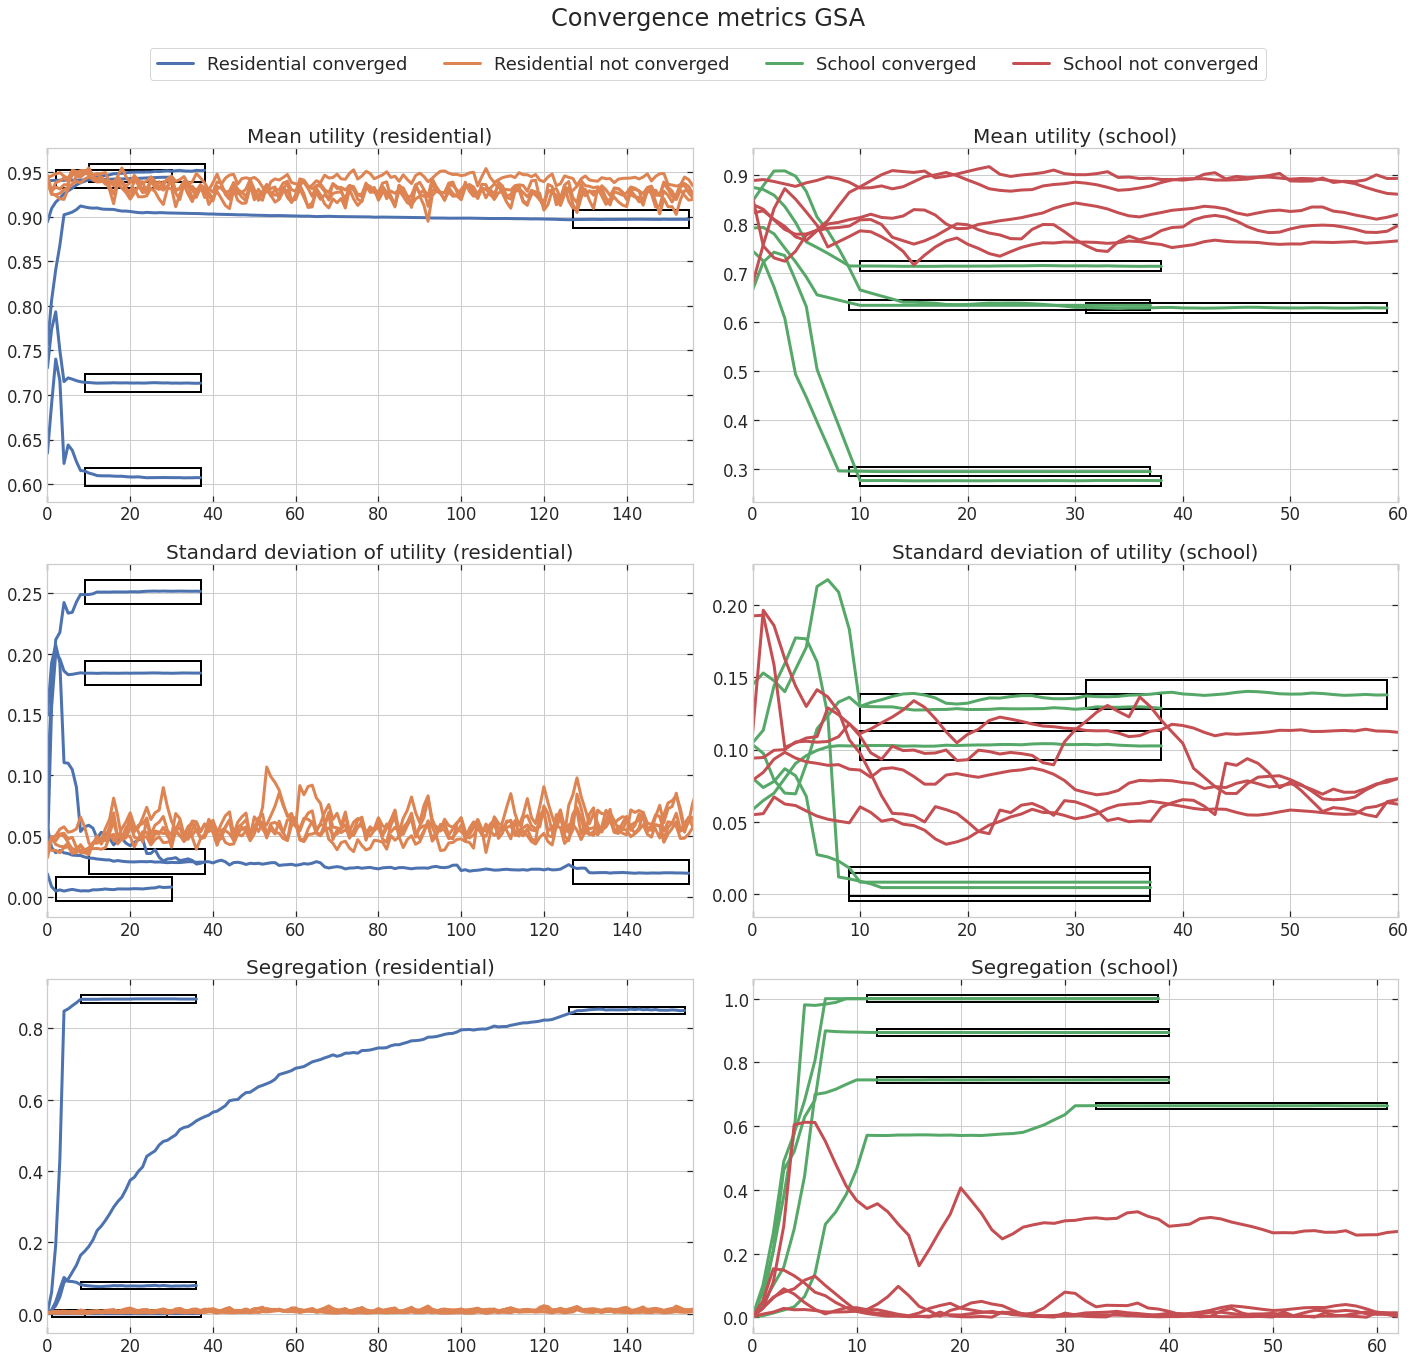

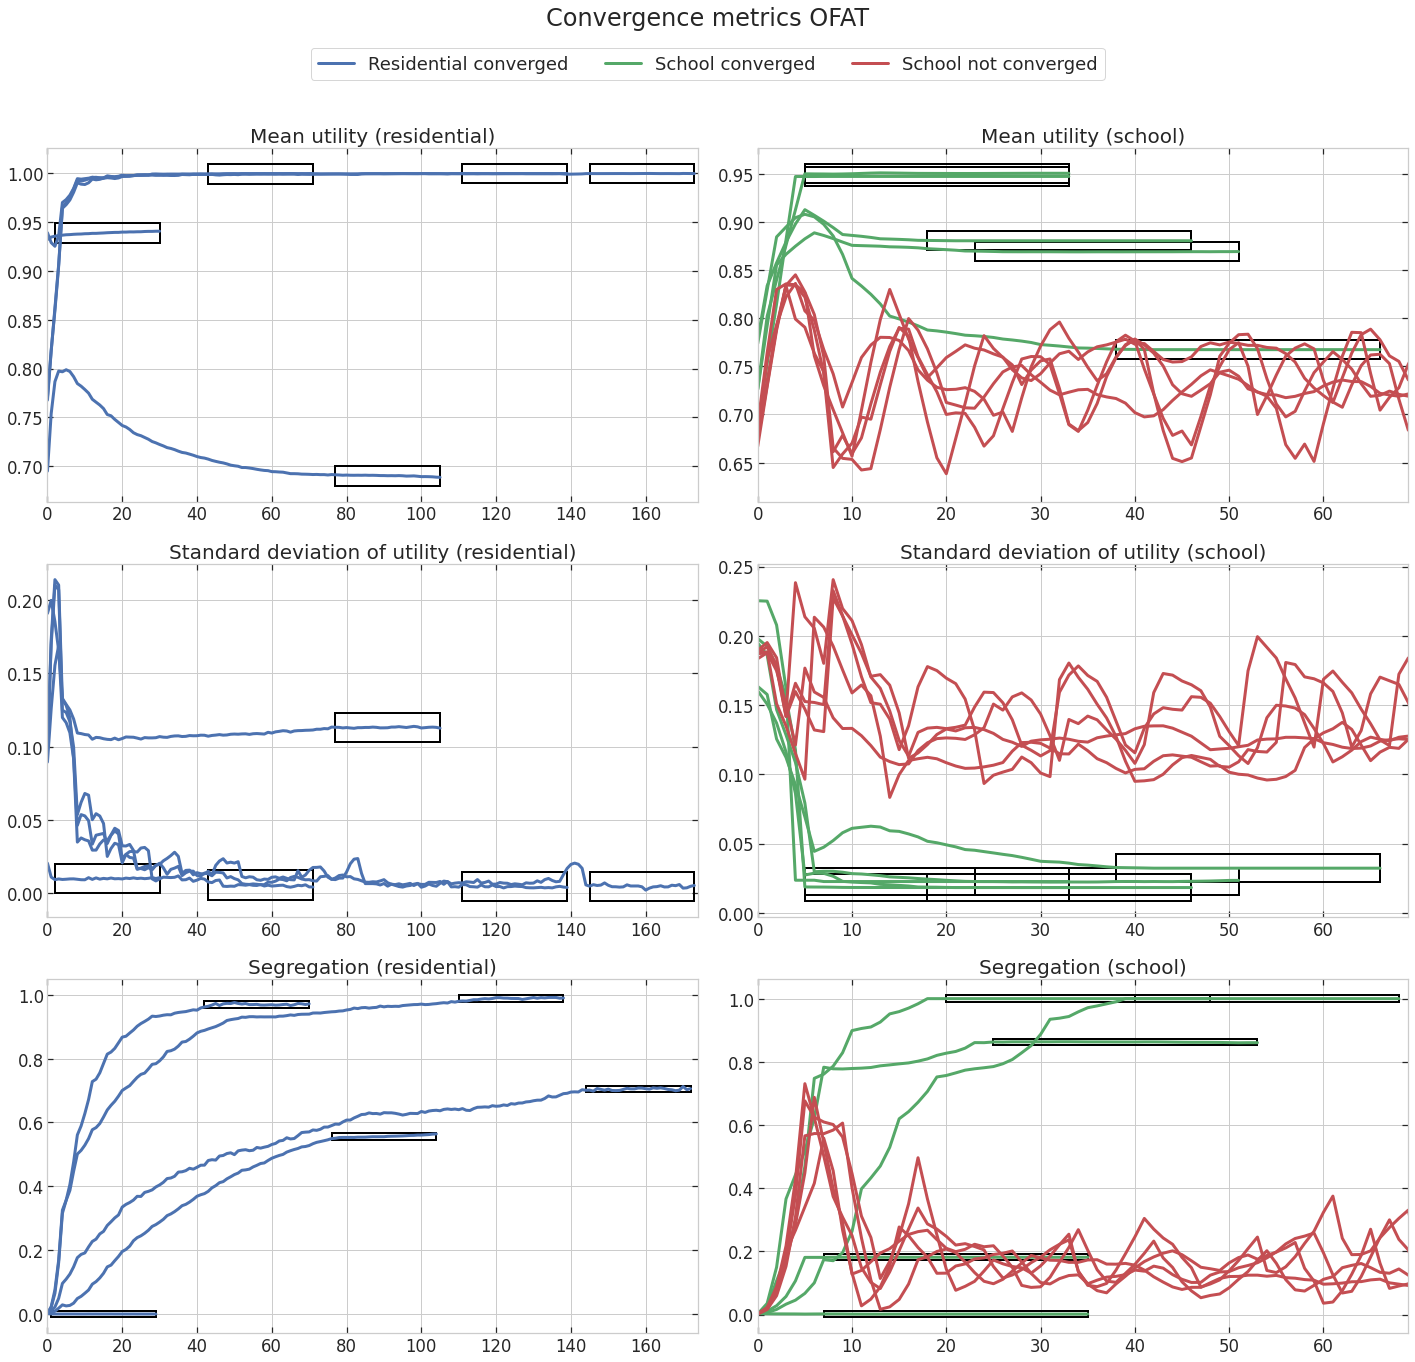

In [13]:
for source in ['gsa-7pars-2000', 'par-sweep-6pars-t']:
    data = pd.read_pickle(f"../experiments/{source}/data/frame.pkl")
    
    # Remove max res steps is 0 as these are automatically not converged
    # for the residential process
    data = data[data.max_res_steps!=0]
    
    if 'gsa' in source:
        title = 'GSA'
    else:
        title = 'OFAT'
    
    nrows = 3
    ncols = 2
    fig, axs = plt.subplots(nrows, ncols, figsize=(20,20))
    fig.suptitle(f'Convergence metrics {title}', fontsize=24)
    sample_size = 5
    all_filenames = {}
    colors = sns.color_palette()
    labels=['Residential converged', 'Residential not converged',
                      'School converged', 'School not converged']
    seed = 1
    index = 0

    for subset in ['res_converged', 'school_converged']:
        for boolean in [True, False]:
            sample_subset = data[data[subset]==boolean]
            if boolean:
                all_filenames[subset] = (
                    sample_subset.filename.sample(n=sample_size, random_state=seed), 
                    colors[index], labels[index])
            else:
                try:
                    all_filenames['not_' + subset] = (
                        sample_subset.filename.sample(n=sample_size, random_state=seed), 
                        colors[index], labels[index])
                except ValueError:
                    index += 1
                    continue
            index += 1


    for subset in all_filenames.keys():

        filenames, colour, label = all_filenames[subset]
        maximum_steps = 0

        for filename in tqdm(filenames):
            temp_data = np.load(f"../experiments/{source}/{filename}.npz", allow_pickle=True)
            household_utility = temp_data['households'][:,:,4]
            mean_u = household_utility.mean(axis=1)
            std_u = household_utility.std(axis=1)

            neighbourhoods = temp_data['neighbourhoods']
            schools = temp_data['schools']
            last_res_step, _, _ = neighbourhoods.shape
            last_school_step, _, _ = schools.shape

            # Calculate residential and school segregation every timestep
            res_seg = np.array([calculate_theil(neighbourhoods[step,:,:2]) \
                       for step in range(last_res_step)])
            school_seg = np.array([calculate_theil(schools[step,:,:2]) \
                              for step in range(last_school_step)])

            for row in range(nrows):

                if row==0:
                    y = mean_u
                elif row==1:
                    y = std_u

                for col in range(ncols):

                    if col==0 and 'school' in subset:
                        continue
                    elif col==1 and 'res' in subset:
                        continue

                    if row==2:
                        if col==0:
                            values = res_seg
                        else:
                            values = school_seg

                    elif col==0:
                        values = y[:last_res_step+1]

                    else:
                        values = y[last_res_step+2:]

                    if row==0:
                        label=label
                    else:
                        label=None

                    sns.lineplot(x=range(len(values)), y=values, ax=axs[row,col], 
                                 color=colour, label=label, legend=False)

                    if 'not' not in subset:
                        if len(values) >= maximum_steps:
                            maximum_steps = len(values)

                        size = 29
                        threshold = 0.01
                        window = values[-size:]
                        rect = patches.Rectangle((len(values)-size, 
                                                 np.mean(window)-threshold), 
                                                 size-1, 2*threshold, 
                                                 linewidth=2, 
                                                 edgecolor='black', 
                                                 facecolor='none')

                        # Add the patch to the Axes
                        axs[row,col].add_patch(rect)
                        axs[row,col].set_xlim(0, maximum_steps)

        for index, title in enumerate(['Mean utility', 
                    'Standard deviation of utility', 'Segregation']):

            axs[index,0].set_title(title + ' (residential)', fontsize=20)
            axs[index,1].set_title(title + ' (school)', fontsize=20)

        for ax in axs.flatten():
            sns.despine(ax=ax, top=False, right=False)
            ax.tick_params(bottom=True, top=True, 
                           left=True, right=True, direction='in')

    legend = fig.legend(ncol=4, bbox_to_anchor=(0.5, 0.94),
                          fontsize=18, loc='center')
    fig.tight_layout(rect=[0, 0.03, 1, 0.94])    

    plot_path = f'../plots/convergence'
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)
    today = date.today()
    plt.savefig(f'{plot_path}/convergence-{source}-{today.strftime("%d-%m-%Y")}.pdf')

# Archive